<a href="https://colab.research.google.com/github/byrcewang/DL_SS2H/blob/main/Transformer_torch_base_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn

# Define the Multi-Head Self-Attention layer
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.head_dim = d_model // n_heads
        assert self.head_dim * n_heads == d_model, "d_model must be divisible by n_heads"
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        # Split the embedding into self.n_heads different heads
        query = query.view(query.shape[0], -1, self.n_heads, self.head_dim)
        key = key.view(key.shape[0], -1, self.n_heads, self.head_dim)
        value = value.view(value.shape[0], -1, self.n_heads, self.head_dim)

        # Transpose to get dimensions batch_size, self.n_heads, seq_len, self.head_dim
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)

        # Calculate the attention scores
        scores = torch.matmul(query, key.transpose(-2, -1)) / self.head_dim
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = torch.nn.functional.softmax(scores, dim=-1)

        out = torch.matmul(attention, value)

        # Reshape to get back to the original input shape
        out = out.transpose(1, 2).contiguous().view(query.shape[0], -1, self.d_model)

        out = self.fc_out(out)
        return out

# Define the Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src, src_mask):
        src2 = self.self_attn(src, src, src, src_mask)
        src = src + self.dropout(src2)
        src = self.norm1(src)

        src2 = self.linear2(self.dropout(torch.nn.functional.relu(self.linear1(src))))
        src = src + self.dropout(src2)
        src = self.norm2(src)

        return src

# Define the Transformer model
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, num_encoder_layers, dim_feedforward, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.encoder = nn.ModuleList(
            [TransformerEncoderLayer(d_model, n_heads, dim_feedforward, dropout) for _ in range(num_encoder_layers)]
        )
        self.src_mask = self.generate_square_subsequent_mask(max_seq_length)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz) == 1, diagonal=1)).transpose(0, 1)
        mask = mask.masked_fill(mask == 0, float('-inf'))
        mask = mask.masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        src = self.embedding(src)
        src = src.permute(1, 0, 2)
        for layer in self.encoder:
            src = layer(src, self.src_mask)
        return src.permute(1, 0, 2)

# Instantiate the model
vocab_size = 10000  # Adjust as needed
d_model = 512
n_heads = 8
num_encoder_layers = 6
dim_feedforward = 2048
max_seq_length = 100
dropout = 0.1

model = Transformer(vocab_size, d_model, n_heads, num_encoder_layers, dim_feedforward, max_seq_length, dropout)

In [3]:
#!pip install torchviz -q

  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1093: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 1638338 / 1638400 (100.0%)
Greatest absolute difference: 2.5161333680152893 at index (44, 25, 484) (up to 1e-05 allowed)
Greatest relative difference: 424117.65192820126 at index (51, 6, 29) (up to 1e-05 allowed)
  _check_trace(


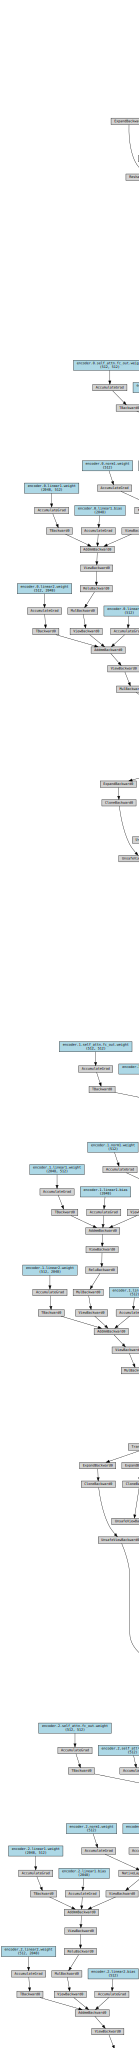

In [6]:
# Visualize the model
from torchviz import make_dot

# Create a dummy input
dummy_input = torch.randint(0, vocab_size, (max_seq_length, 32))  # Fix the order of dimensions

# Forward pass to trace the model
trace_model = torch.jit.trace(model, dummy_input)

# Create a visualization
make_dot(trace_model(dummy_input), params=dict(model.named_parameters()))

In [20]:
# With Chinese comments
import torch  # 导入PyTorch库
import torch.nn as nn  # 导入PyTorch的神经网络模块

# 定义多头自注意力层
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads  # 多头注意力的头数
        self.d_model = d_model  # 模型的维度
        self.head_dim = d_model // n_heads  # 每个头的维度
        assert self.head_dim * n_heads == d_model, "d_model必须能被n_heads整除"
        self.wq = nn.Linear(d_model, d_model)  # 查询向量权重矩阵
        self.wk = nn.Linear(d_model, d_model)  # 键向量权重矩阵
        self.wv = nn.Linear(d_model, d_model)  # 值向量权重矩阵
        self.fc_out = nn.Linear(d_model, d_model)  # 最终输出的全连接层

    def forward(self, query, key, value, mask):
        # 将嵌入向量分成不同的头
        query = query.view(query.shape[0], -1, self.n_heads, self.head_dim)
        key = key.view(key.shape[0], -1, self.n_heads, self.head_dim)
        value = value.view(value.shape[0], -1, self.n_heads, self.head_dim)

        # 转置以获得维度 batch_size, self.n_heads, seq_len, self.head_dim
        query = query.transpose(1, 2)
        key = key.transpose(1, 2)
        value = value.transpose(1, 2)

        # 计算注意力得分
        scores = torch.matmul(query, key.transpose(-2, -1)) / self.head_dim
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = torch.nn.functional.softmax(scores, dim=-1)

        out = torch.matmul(attention, value)

        # 重塑以恢复原始输入形状
        out = out.transpose(1, 2).contiguous().view(query.shape[0], -1, self.d_model)

        out = self.fc_out(out)
        return out

# 定义Transformer编码器层
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src, src_mask):
        src2 = self.self_attn(src, src, src, src_mask)
        src = src + self.dropout(src2)
        src = self.norm1(src)

        src2 = self.linear2(self.dropout(torch.nn.functional.relu(self.linear1(src))))
        src = src + self.dropout(src2)
        src = self.norm2(src)

        return src

# 定义Transformer模型
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, num_encoder_layers, dim_feedforward, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)  # 嵌入层
        self.encoder = nn.ModuleList(
            [TransformerEncoderLayer(d_model, n_heads, dim_feedforward, dropout) for _ in range(num_encoder_layers)]
        )  # 编码器层的堆叠
        self.src_mask = self.generate_square_subsequent_mask(max_seq_length)  # 创建遮挡矩阵

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz) == 1, diagonal=1)).transpose(0, 1)  # 生成上三角遮挡矩阵
        mask = mask.masked_fill(mask == 0, float('-inf'))  # 将遮挡矩阵中的0替换为负无穷
        mask = mask.masked_fill(mask == 1, float(0.0))  # 将遮挡矩阵中的1替换为0
        return mask

    def forward(self, src):
        src = self.embedding(src)  # 输入数据通过嵌入层
        src = src.permute(1, 0, 2)  # 重排维度
        for layer in self.encoder:  # 通过多个编码器层
            src = layer(src, self.src_mask)
        return src.permute(1, 0, 2)  # 恢复原始维度顺序

# 实例化模型
vocab_size = 10000  # 词汇表大小（根据实际情况调整）
d_model = 512  # 模型的维度
n_heads = 8  # 多头自注意力的头数
num_encoder_layers = 6  # 编码器层的数量
dim_feedforward = 2048  # 全连接层的隐藏层维度
max_seq_length = 100  # 最大序列长度
dropout = 0.1  # 丢弃率

model = Transformer(vocab_size, d_model, n_heads, num_encoder_layers, dim_feedforward, max_seq_length, dropout)  # 创建Transformer模型实例